In [1]:
import pandas as pd
from ast import literal_eval
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import xgboost as xgb
from sklearn.metrics import accuracy_score
from tensorflow.keras import Model
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
import functions

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Načtení a rozdělení dat

In [2]:
data = pd.read_csv('clean_data.csv', converters={'Lyrics': literal_eval})

In [3]:
X = data['Lyrics']
y = data['Genre']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify = y_train)

In [5]:
display(X_train.shape)
display(y_train.shape)
display(X_val.shape)
display(y_val.shape)
display(X_test.shape)
display(y_test.shape)

(7587,)

(7587,)

(2530,)

(2530,)

(3373,)

(3373,)

# Tf-idf reprezentace

Zkoušel jsem bag of words a tf-idf reprezentaci a tf-idf vyšla o trochu lépe. Experimentoval jsem s různou velikostí slovní zásoby a nejlepších výsledků jsem dosáhl s co největší slovní zásobou. Velikost jsem omezil na 10000, aby se data vešla na RAM.

In [6]:
vocabTopWords = functions.create_vocab(X_train, 10000)
vocabLen = len(vocabTopWords)

In [7]:
# to each word assigns a ratio of documents in which the word is present
def create_doc_frequencies(data):
  docFrequencies = {}
  numDocuments = X_train.shape[0]
  for word in vocabTopWords:
    docFrequency = 0
    for text in data:
      if word in text:
        docFrequency += 1
    docFrequencies[word] = docFrequency / numDocuments
  return docFrequencies

In [8]:
docFrequencies = create_doc_frequencies(X_train)

In [9]:
# creates tf-idf representations of given data from given document frequencies
def create_tf_idf(data, docFrequencies):  
  newData = []
  docFrequenciesList = list(docFrequencies.values())
  for text in data:
    bag = [0] * vocabLen
    for word in text:
      if word in vocabTopWords:
        bag[vocabTopWords[word]] += 1 # bag of words representation
    for i in range(len(bag)):
      bag[i] = bag[i] / len(text) # term frequency representation
      bag[i] = bag[i] * np.log(1 / docFrequenciesList[i]) # tf-idf representation
    newData.append(bag)
  return newData

In [10]:
X_train = create_tf_idf(X_train, docFrequencies)
X_val = create_tf_idf(X_val, docFrequencies)
X_test = create_tf_idf(X_test, docFrequencies)

# Reprezentace vysvětlované proměnné

In [11]:
y_train = y_train.apply(lambda x: functions.genre_to_class[x])
y_val = y_val.apply(lambda x: functions.genre_to_class[x])
y_test = y_test.apply(lambda x: functions.genre_to_class[x])

# DNN

In [12]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [13]:
X_train.shape

(7587, 10000)

Experimentoval jsem s různými strukturami sítě, nicméně kvalita výsledků se nijak zásadně nelišila. Pro snížení přeučení jsem použil dropout.

In [14]:
def func_model():
    input_layer = Input(shape=(vocabLen,))
    flatten = Flatten()(input_layer)
    dense1 = Dense(1024, activation='relu')(flatten)
    dropout1 = Dropout(rate=0.2)(dense1)
    dense2 = Dense(1024, activation='relu')(dropout1)
    dropout2 = Dropout(rate=0.2)(dense2)
    concat = Concatenate()([dense1, dense2, dropout1, dropout2])
    output_layer = Dense(5, activation='softmax')(concat)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [15]:
modelDNN = func_model()

In [16]:
modelDNN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10000)]      0           []                               
                                                                                                  
 flatten (Flatten)              (None, 10000)        0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1024)         10241024    ['flatten[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1024)         0           ['dense[0][0]']                  
                                                                                              

Použil jsem checkpoint pro načtení vah při nejvyšší validační přesnosti.

In [17]:
mc = tf.keras.callbacks.ModelCheckpoint('./weights_dnn_best.h5',
                                     monitor='val_accuracy',
                                     save_weights_only=True,
                                     save_best_only=True)

In [18]:
modelDNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model jsem nechal trénovat pouze 10 epoch, protože brzy dochází k přeučení.

In [19]:
history = modelDNN.fit(X_train, y_train,
                    epochs=10,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose = 1,
                    callbacks=[mc])

Epoch 1/10
30/30 [==============================] - 11s 330ms/step - loss: 1.4303 - accuracy: 0.3924 - val_loss: 1.1633 - val_accuracy: 0.4874
Epoch 2/10
30/30 [==============================] - 10s 319ms/step - loss: 0.8353 - accuracy: 0.6929 - val_loss: 1.1384 - val_accuracy: 0.5577
Epoch 3/10
30/30 [==============================] - 9s 313ms/step - loss: 0.3983 - accuracy: 0.8661 - val_loss: 1.4152 - val_accuracy: 0.5474
Epoch 4/10
30/30 [==============================] - 9s 309ms/step - loss: 0.1796 - accuracy: 0.9487 - val_loss: 1.7391 - val_accuracy: 0.5411
Epoch 5/10
30/30 [==============================] - 10s 325ms/step - loss: 0.0855 - accuracy: 0.9780 - val_loss: 2.0489 - val_accuracy: 0.5340
Epoch 6/10
30/30 [==============================] - 10s 328ms/step - loss: 0.0409 - accuracy: 0.9921 - val_loss: 2.3099 - val_accuracy: 0.5344
Epoch 7/10
30/30 [==============================] - 10s 318ms/step - loss: 0.0274 - accuracy: 0.9958 - val_loss: 2.5070 - val_accuracy: 0.5292
E

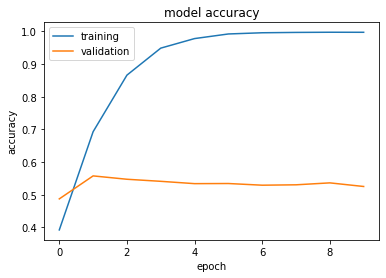

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [21]:
modelDNN.load_weights('weights_dnn_best.h5')

Funkce na predikování

In [22]:
# makes a predictions of given songs
def predict_genre(model, songs):
  songs = functions.clean_data(songs)
  songs = functions.split_data(songs)
  songs = functions.stem(songs)
  songs = functions.remove_stopwords(songs)
  songs = create_tf_idf(songs, docFrequencies)
  songs = np.array(songs)
  return model.predict(songs)

Predikce hip-hopové písničky Eminem - The way I am

In [23]:
predict_genre(modelDNN, ['Man, whatever\nDre, just let it run\nAyo, turn the beat up a little bit\nAyo, this song is for anyone...\nFuck it, just shut up and listen, ayo\nI sit back with this pack of Zig-Zags and this bag\nOf this weed, it gives me the shit needed to be\nThe most meanest MC on this on this Earth\nAnd since birth I\'ve been cursed with this curse to just curse\nAnd just blurt this berserk and bizarre shit that works\nAnd it sells and it helps in itself to relieve all this tension\nDispensing these sentences, getting this stress\nThat\'s been eating me recently off of this chest\nAnd I rest again peacefully\nBut at least have the decency in you\nTo leave me alone, when you freaks see me out\nIn the streets when I\'m eating or feeding my daughter\nTo not come and speak to me\nI don\'t know you, and no, I don\'t owe you a mothafuckin\' thing\nI\'m not Mr. N\'Sync, I\'m not what your friends think\nI\'m not Mr. Friendly, I can be a prick if you tempt me\nMy tank is on empty, no patience is in me\nAnd if you offend me, I\'m lifting you ten feet in the air\nI don\'t care who was there and who saw me just jaw you\nGo call you a lawyer, file you a lawsuit\nI\'ll smile in the courtroom and buy you a wardrobe\nI\'m tired of all you, I don\'t mean to be mean\nBut that\'s all I can be, it\'s just me\nAnd I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am, huh\nI don\'t know, it\'s just the way I am\nSometimes I just feel like my father\nI hate to be bothered with all of this nonsense, it\'s constant\nAnd, oh, it\'s his lyrical content, the song Guilty Conscience\nHas gotten such rotten responses\nAnd all of this controversy circles me\nAnd it seems like the media immediately points a finger at me\nSo I point one back at \'em, but not the index or pinkie\nOr the ring or the thumb, it\'s the one you put up\nWhen you don\'t give a fuck, when you won\'t just put up\nWith the bullshit they pull, \'cause they full of shit too\nWhen a dude\'s getting bullied and shoots up his school\nAnd they blame it on Marilyn and the heroin\nWhere were the parents at? And look where it\'s at!\nMiddle America, now it\'s a tragedy\nNow it\'s so sad to see, an upper-class city\nHavin\' this happenin\'\nThen attack Eminem \'cause I rap this way\nBut I\'m glad, \'cause they feed me the fuel that I need\nFor the fire to burn and it\'s burning, and I have returned\nAnd I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nI don\'t know, it\'s just the way I am\nI\'m so sick and tired of being admired\nThat I wish that I would just die or get fired\nAnd dropped from my label, let\'s stop with the fables\nI\'m not gonna be able to top on "My Name Is"\nAnd pigeon-holed into some poppy sensation\nTo cop me rotation at rock-n-roll stations\nAnd I just do not got the patience\nTo deal with these cocky Caucasians\nWho think I\'m some wigger who just tries to be black\n\'Cause I talk with an accent, and grab on my balls\nSo they always keep asking the same fucking questions\nWhat school did I go to, what hood I grew up in\nThe why, the who, what, when, the where and the how\n\'Til I\'m grabbing my hair and I\'m tearin\' it out\n\'Cause they driving me crazy, I can\'t take it\nI\'m racin\', I\'m pacin\', I stand and I sit\nAnd I\'m thankful for every fan that I get\nBut I can\'t take a shit in the bathroom\nWithout someone standing by it\nNo, I won\'t sign you an autograph\nYou can call me an asshole, I\'m glad, \'cause...\nI am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nI don\'t know, it\'s just the way I am'])

array([[0.02856248, 0.06549612, 0.0036677 , 0.02387731, 0.8783964 ]],
      dtype=float32)

Hip-hopu odpovídá poslední neuron, model tedy predikuje správně.

# XGB

In [24]:
modelXGB = xgb.XGBClassifier()
modelXGB.fit(X_train, y_train)

preds = modelXGB.predict(X_val)
accuracy_score(y_val, preds)

0.5320158102766799

Predikce hip-hopové písničky Eminem - The way I am

In [25]:
predict_genre(modelXGB, ['Man, whatever\nDre, just let it run\nAyo, turn the beat up a little bit\nAyo, this song is for anyone...\nFuck it, just shut up and listen, ayo\nI sit back with this pack of Zig-Zags and this bag\nOf this weed, it gives me the shit needed to be\nThe most meanest MC on this on this Earth\nAnd since birth I\'ve been cursed with this curse to just curse\nAnd just blurt this berserk and bizarre shit that works\nAnd it sells and it helps in itself to relieve all this tension\nDispensing these sentences, getting this stress\nThat\'s been eating me recently off of this chest\nAnd I rest again peacefully\nBut at least have the decency in you\nTo leave me alone, when you freaks see me out\nIn the streets when I\'m eating or feeding my daughter\nTo not come and speak to me\nI don\'t know you, and no, I don\'t owe you a mothafuckin\' thing\nI\'m not Mr. N\'Sync, I\'m not what your friends think\nI\'m not Mr. Friendly, I can be a prick if you tempt me\nMy tank is on empty, no patience is in me\nAnd if you offend me, I\'m lifting you ten feet in the air\nI don\'t care who was there and who saw me just jaw you\nGo call you a lawyer, file you a lawsuit\nI\'ll smile in the courtroom and buy you a wardrobe\nI\'m tired of all you, I don\'t mean to be mean\nBut that\'s all I can be, it\'s just me\nAnd I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am, huh\nI don\'t know, it\'s just the way I am\nSometimes I just feel like my father\nI hate to be bothered with all of this nonsense, it\'s constant\nAnd, oh, it\'s his lyrical content, the song Guilty Conscience\nHas gotten such rotten responses\nAnd all of this controversy circles me\nAnd it seems like the media immediately points a finger at me\nSo I point one back at \'em, but not the index or pinkie\nOr the ring or the thumb, it\'s the one you put up\nWhen you don\'t give a fuck, when you won\'t just put up\nWith the bullshit they pull, \'cause they full of shit too\nWhen a dude\'s getting bullied and shoots up his school\nAnd they blame it on Marilyn and the heroin\nWhere were the parents at? And look where it\'s at!\nMiddle America, now it\'s a tragedy\nNow it\'s so sad to see, an upper-class city\nHavin\' this happenin\'\nThen attack Eminem \'cause I rap this way\nBut I\'m glad, \'cause they feed me the fuel that I need\nFor the fire to burn and it\'s burning, and I have returned\nAnd I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nI don\'t know, it\'s just the way I am\nI\'m so sick and tired of being admired\nThat I wish that I would just die or get fired\nAnd dropped from my label, let\'s stop with the fables\nI\'m not gonna be able to top on "My Name Is"\nAnd pigeon-holed into some poppy sensation\nTo cop me rotation at rock-n-roll stations\nAnd I just do not got the patience\nTo deal with these cocky Caucasians\nWho think I\'m some wigger who just tries to be black\n\'Cause I talk with an accent, and grab on my balls\nSo they always keep asking the same fucking questions\nWhat school did I go to, what hood I grew up in\nThe why, the who, what, when, the where and the how\n\'Til I\'m grabbing my hair and I\'m tearin\' it out\n\'Cause they driving me crazy, I can\'t take it\nI\'m racin\', I\'m pacin\', I stand and I sit\nAnd I\'m thankful for every fan that I get\nBut I can\'t take a shit in the bathroom\nWithout someone standing by it\nNo, I won\'t sign you an autograph\nYou can call me an asshole, I\'m glad, \'cause...\nI am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nI don\'t know, it\'s just the way I am'])

array([4])

Model opět predikuje správně.

# Vyhodnocení

Jako nejlepší model dopadla tf-idf reprezentace s DNN. Tento model byl spuštěn na testovacích datech.

In [26]:
modelDNN.evaluate(X_test, y_test)

106/106 [==============================] - 3s 29ms/step - loss: 1.1358 - accuracy: 0.5482


[1.1358083486557007, 0.5481767058372498]